# Image Captioning

[Paper here](https://cs.stanford.edu/people/karpathy/cvpr2015.pdf)


In [1]:
import re

from rich import print
from tqdm.notebook import tqdm

%load_ext rich


In [2]:
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import torch
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
from torchvision import transforms
from torchvision.utils import make_grid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.enable_system_metrics_logging()


In [4]:
# Hyperparameters

BATCH_SIZE = 32
N_EPOCHS = 10
LEARNING_RATE = 1e-3
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

## Load the dataset


### Preprocess the captions

In [5]:
with open("./data/Flickr8k.token.txt") as f:
    captions = f.read().splitlines()

captions[:10]


[
    '1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
    '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
    '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
    '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
    '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .',
    '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting',
    '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .',
    '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .',
    '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .',
    '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .'
]

In [6]:
captions_dict = {}

for line in captions:
    contents = line.split("\t")

    if len(contents) < 2:
        continue

    filename, caption = contents[0], contents[1]

    filename = filename[:-2]

    if filename in captions_dict.keys():
        captions_dict[filename].append(caption)
    else:
        captions_dict[filename] = [caption]


In [7]:
def get_split_ids(split):
    with open(f"./data/Flickr_8k.{split}Images.txt") as f:
        return f.read().splitlines()

train_ids = get_split_ids("train")
val_ids = get_split_ids("dev")
test_ids = get_split_ids("test")

In [8]:
train_transform = transforms.Compose(
    [
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
    ]
)


### Define the tokenizer

In [9]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {
            0: "<PAD>",
            1: "<SOS>",
            2: "<EOS>",
            3: "<UNK>",
        }

        self.stoi = {v: k for k, v in self.itos.items()}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenize(text):
        text = text.lower()
        text = re.sub(r"[^a-z0-9\s]", "", text)
        return text.split()

    def build_vocabulary(self, captions):
        frequencies = {}
        idx = 4

        for caption in captions:
            for word in self.tokenize(caption):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenize(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]


In [10]:
tokenizer = Vocabulary(freq_threshold=5)

tokenizer.build_vocabulary(
    [caption for captions in captions_dict.values() for caption in captions]
)

print(f"Total number of tokens in vocabulary: {len(tokenizer)}")
print(f'Sample tokenized caption: {tokenizer.numericalize("A black dog is running")}')


Total number of tokens in vocabulary: 2995

Sample tokenized caption: [4, 19, 5, 16, 28]

In [11]:
class CustomCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_idx)

        return imgs, targets

### Define the custom dataset

In [12]:
class Flickr8kDataset(Dataset):
    def __init__(self, tokenizer, image_ids, captions_dict, transform=None):
        self.data = []
        self.transform = transform
        self.tokenizer = tokenizer

        for img_id in image_ids:
            if img_id in captions_dict:
                for caption in captions_dict[img_id]:
                    self.data.append((img_id, caption))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_id, caption = self.data[idx]
        img_path = f"./data/images/{img_id}"
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        numericalized_captions = [self.tokenizer.stoi["<SOS>"]]
        numericalized_captions += self.tokenizer.numericalize(caption)
        numericalized_captions.append(self.tokenizer.stoi["<EOS>"])

        return image, torch.tensor(numericalized_captions)

In [13]:
# Create datasets
train_dataset = Flickr8kDataset(
    tokenizer, train_ids, captions_dict, transform=train_transform
)
val_dataset = Flickr8kDataset(
    tokenizer, val_ids, captions_dict, transform=test_transform
)
test_dataset = Flickr8kDataset(
    tokenizer, test_ids, captions_dict, transform=test_transform
)

In [14]:
pad_idx = tokenizer.stoi["<PAD>"]

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=CustomCollate(pad_idx=pad_idx),
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=CustomCollate(pad_idx=pad_idx),
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=CustomCollate(pad_idx=pad_idx),
)


In [15]:
def reverse_transform(x, train=True):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    if train:
        x = x * torch.tensor(std).unsqueeze(1).unsqueeze(1)
        x = x + torch.tensor(mean).unsqueeze(1).unsqueeze(1)

    return transforms.ToPILImage()(x)


### View a sample of the dataset

In [16]:
len(train_loader), len(val_loader), len(test_loader)

(938, 157, 157)

In [17]:
sample_batch = next(iter(train_loader))

imgs, captions = sample_batch

print(f"Image batch shape: {imgs.shape}")
print(f"Caption batch shape: {captions.shape}")

Image batch shape: torch.Size([32, 3, 224, 224])

Caption batch shape: torch.Size([32, 18])

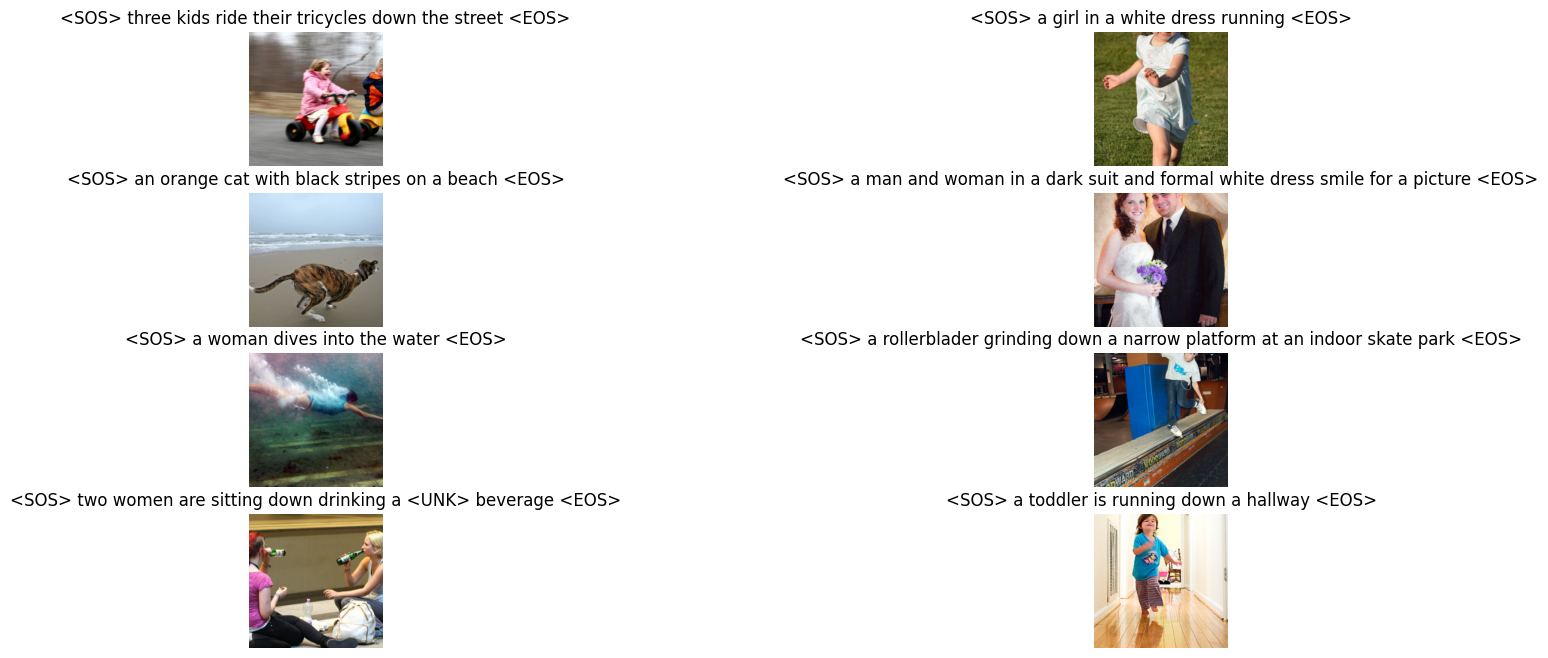

In [18]:
fig, axs = plt.subplots(4, 2, figsize=(20, 8))
for idx in range(8):
    img = imgs[idx]
    label = captions[idx]

    img = reverse_transform(img)
    ax = axs[idx // 2, idx % 2]
    ax.imshow(img)
    ax.set_title(
        f"{' '.join([tokenizer.itos[i.item()] for i in label if i != pad_idx])}"
    )
    ax.axis("off")

plt.show()


## Build the architecture


Tokenized caption: tensor([  1,   5, 526,   4,  25, 174,   2])

Original caption: <SOS> dog catching a red frisbee <EOS>

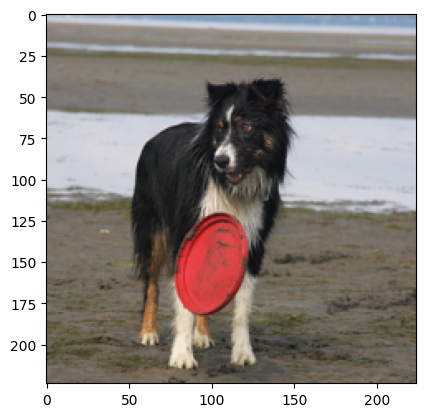

In [19]:
random_idx = 23
img, caption = train_dataset[random_idx]
plt.imshow(reverse_transform(img))
print(f"Tokenized caption: {caption}")
print(f'Original caption: {" ".join([tokenizer.itos[i.item()] for i in caption])}')


### Encoder model

In [20]:
class Encoder(nn.Module):
    def __init__(self, d_embed, debug=False):
        super(Encoder, self).__init__()
        self.vgg16 = models.vgg16(weights="IMAGENET1K_V1")
        self.embed = nn.Linear(self.vgg16.classifier[-1].in_features, d_embed)

        self.vgg16.classifier = nn.Sequential(
            *list(self.vgg16.classifier.children())[:-1]
        )

        for param in self.vgg16.parameters():
            param.requires_grad = False

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x):
        self._debug_print(x, "[ENCODER] Input")
        x = self.vgg16(x)
        self._debug_print(x, "[ENCODER] Features")
        x = self.embed(x)
        self._debug_print(x, "[ENCODER] Embedded")
        return x


In [21]:
encoded_output = Encoder(d_embed=512, debug=True)(img.unsqueeze(0))

[ENCODER] Input: torch.Size([1, 3, 224, 224])

[ENCODER] Features: torch.Size([1, 4096])

[ENCODER] Embedded: torch.Size([1, 512])

### Decoder model

In [22]:
class Decoder(nn.Module):
    def __init__(self, d_embed, d_hidden, n_layers, d_vocab, debug=False):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(d_vocab, d_embed)
        self.lstm = nn.LSTM(d_embed, d_hidden, n_layers, batch_first=True)
        self.linear = nn.Linear(d_hidden, d_vocab)
        self.dropout = nn.Dropout(0.5)

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x, target):
        self._debug_print(x, "[DECODER] Features")

        # B x S -> B x S x E
        embeddings = self.dropout(self.embed(target))
        self._debug_print(embeddings, "[DECODER] Caption embeddings")

        # B x 1 x E >-< B x S x E -> B x 1 + S x E
        embeddings = torch.cat((x.unsqueeze(1), embeddings[:, :-1]), dim=1)
        self._debug_print(embeddings, "[DECODER] Concatenated")

        # B x S x E -> B x S x H
        hiddens, _ = self.lstm(embeddings)
        self._debug_print(hiddens, "[DECODER] LSTM outputs")

        # B x S x H -> B x S x V
        outputs = self.linear(hiddens)
        self._debug_print(outputs, "[DECODER] Linear outputs")

        return outputs


In [23]:
decoded_output = Decoder(
    d_embed=512, d_hidden=256, n_layers=2, d_vocab=len(tokenizer), debug=True
)(Encoder(d_embed=512)(imgs), captions)


[DECODER] Features: torch.Size([32, 512])

[DECODER] Caption embeddings: torch.Size([32, 18, 512])

[DECODER] Concatenated: torch.Size([32, 18, 512])

[DECODER] LSTM outputs: torch.Size([32, 18, 256])

[DECODER] Linear outputs: torch.Size([32, 18, 2995])

In [24]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, d_embed, d_hidden, n_layers, d_vocab, tokenizer, debug=False):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = Encoder(d_embed=d_embed, debug=debug)
        self.decoder = Decoder(
            d_embed=d_embed,
            d_hidden=d_hidden,
            n_layers=n_layers,
            d_vocab=d_vocab,
            debug=debug,
        )

        self.debug = debug

        self.tokenizer = tokenizer

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x, target):
        self._debug_print(x, "Input")
        x = self.encoder(x)
        x = self.decoder(x, target)
        self._debug_print(x, "Output")

        return x

    def generate_caption(self, x, max_len=20):
        result_caption = [self.tokenizer.stoi["<SOS>"]]

        with torch.no_grad():
            x = self.encoder(x).unsqueeze(0)

            states = None

            for _ in range(max_len):
                self._debug_print(x, "Features")
                hidden, states = self.decoder.lstm(x, states)
                self._debug_print(hidden, "Hidden")
                output = self.decoder.linear(hidden.squeeze(0))
                self._debug_print(output, "Output")
                predicted_token = output.argmax(1)

                result_caption.append(predicted_token.item())

                x = self.decoder.embed(predicted_token).unsqueeze(0)

                if self.tokenizer.itos[predicted_token.item()] == "<EOS>":
                    break

        return [self.tokenizer.itos[token] for token in result_caption]


In [25]:
model = ImageCaptioningModel(
    d_embed=512,
    d_hidden=512,
    n_layers=2,
    d_vocab=len(tokenizer),
    tokenizer=tokenizer,
    debug=False,
)

model(imgs, captions)



tensor([[[-6.5840e-03,  5.5425e-02, -1.2700e-02,  ...,  1.1821e-02,
          -7.4745e-03, -1.0330e-02],
         [ 4.1015e-03,  7.6268e-02, -1.7516e-02,  ...,  8.1198e-03,
          -3.9608e-03,  2.3029e-04],
         [-2.2270e-03,  8.4829e-02, -7.4030e-03,  ...,  1.8998e-02,
           1.1412e-02,  2.8397e-02],
         ...,
         [-4.9748e-02,  7.0122e-02, -7.3521e-02,  ...,  9.4035e-03,
           1.9622e-02, -6.2173e-03],
         [-4.5808e-02,  6.6912e-02, -6.8559e-02,  ..., -3.5560e-03,
           2.5123e-02, -1.0911e-02],
         [-5.4821e-02,  7.4387e-02, -7.4466e-02,  ..., -3.4880e-03,
           1.8182e-03, -2.6290e-02]],

        [[-6.5364e-03,  4.7764e-02, -5.9260e-03,  ...,  3.5850e-03,
           5.5462e-03, -5.5954e-03],
         [ 1.8549e-02,  4.4689e-02,  4.8777e-03,  ...,  3.1819e-03,
           2.5539e-03,  1.1310e-02],
         [ 4.6203e-02,  7.2597e-02,  8.3152e-03,  ...,  3.3974e-03,
           4.6568e-03, -7.7922e-03],
         ...,
         [-4.9724e-02,  

In [26]:
model.generate_caption(img.unsqueeze(0), max_len=10)


[
    '<SOS>',
    'waterskier',
    'throwing',
    'cup',
    'cup',
    'headed',
    'headed',
    'drinking',
    'teenager',
    'filled',
    'filled'
]

In [27]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the model: {total_params}")

Total number of parameters in the model: 143630579

## Train the model

In [28]:
model = ImageCaptioningModel(
    d_embed=512,
    d_hidden=256,
    n_layers=2,
    d_vocab=len(tokenizer),
    tokenizer=tokenizer,
    debug=False,
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

optimizer = torch.optim.RMSprop(
    model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY
)


In [29]:
mlflow.set_experiment(experiment_name="image-captioning")

<Experiment: artifact_location='mlflow-artifacts:/559146244467130810', creation_time=1722719869459, experiment_id='559146244467130810', last_update_time=1722719869459, lifecycle_stage='active', name='image-captioning', tags={}>

In [30]:
with mlflow.start_run() as run:
    run_id = run.info.run_id
    # Log hyperparameters
    mlflow.log_params(
        {
            "N_EPOCHS": N_EPOCHS,
            "LEARNING_RATE": LEARNING_RATE,
            "MOMENTUM": MOMENTUM,
            "WEIGHT_DECAY": WEIGHT_DECAY,
            "BATCH_SIZE": BATCH_SIZE,
            "Optimizer": optimizer.__class__.__name__,
            "Loss Function": criterion.__class__.__name__,
            "ENCODER": "vgg16",
            "D_EMBED": 512,
            "D_HIDDEN": 256,
            "N_LAYERS": 2,
        }
    )

    for epoch in tqdm(range(N_EPOCHS), desc="Epochs"):
        # ---------- Training ----------
        train_loss = 0

        for batch, (inputs, captions) in enumerate(tqdm(train_loader, desc="Training")):
            model.train()

            inputs, captions = inputs.to(device), captions.to(device)

            outputs = model(inputs, captions[:, :-1])

            outputs = outputs.reshape(-1, outputs.shape[2])
            targets = captions[:, 1:].reshape(-1)

            loss = criterion(outputs, targets)

            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

            optimizer.step()

        train_loss /= len(train_loader)
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}")
        mlflow.log_metric("train_loss", train_loss, step=epoch)

        # ---------- Validation ----------

        val_loss = 0

        model.eval()
        with torch.inference_mode():
            for inputs, captions in tqdm(val_loader, desc="Validation"):
                inputs, captions = inputs.to(device), captions.to(device)

                outputs = model(inputs, captions[:, :-1])
                outputs = outputs.reshape(-1, outputs.shape[2])
                targets = captions[:, 1:].reshape(-1)
                loss = criterion(outputs, targets)

                val_loss += loss.item()

            val_loss /= len(val_loader)
            print(f"Epoch: {epoch} | Val Loss: {val_loss:.4f}")
            mlflow.log_metric("val_loss", val_loss, step=epoch)
    #     mlflow.log_metric("val_acc", val_acc, step=epoch)

mlflow.pytorch.log_model(model, "model")

2024/08/03 17:42:20 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 4.4436

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 0 | Val Loss: 4.3064

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 4.2708

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 1 | Val Loss: 4.2802

Training:   0%|          | 0/938 [00:00<?, ?it/s]

2024/08/03 19:05:29 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/08/03 19:05:29 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:36                                                                                   │
│                                                                                                  │
│   33 │   │   │                                                                                   │
│   34 │   │   │   loss = criterion(outputs, targets)                                              │
│   35 │   │   │                                                                                   │
│ ❱ 36 │   │   │   train_loss += loss.item()                                                       │
│   37 │   │   │                                                                                   │
│   38 │   │   │   optimizer.zero_grad()                                                           │
│   39 │   │   │   loss.backward()                                                                 │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

## Test the model

In [ ]:
model.eval()

test_loss = 0

# with mlflow.start_run(run_id=run_id):
with torch.inference_mode():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        test_loss += criterion(outputs, labels)

        top3_preds = outputs.topk(k=3, dim=-1).indices

    test_loss /= len(test_loader)

print(
    f"Test Loss: {test_loss:.4f}"
)

# mlflow.log_metric("test_loss", test_loss)
# mlflow.log_metric("test_acc", test_acc)

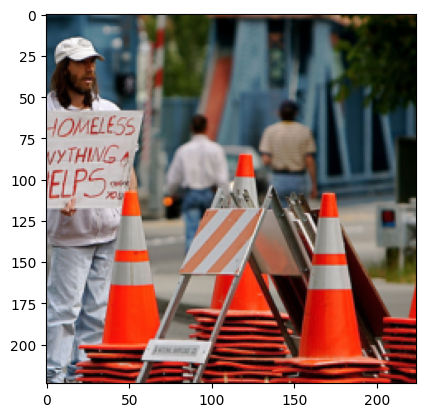

Original caption: <SOS> <UNK> of orange safety cones in front of a man holding up a homeless sign <EOS>

In [36]:
sample_test_image, sample_test_label = test_loader.dataset[299]

plt.imshow(reverse_transform(sample_test_image, train=False))
plt.show()

print(
    f"Original caption: {' '.join([tokenizer.itos[i.item()] for i in sample_test_label])}"
)


In [37]:
prediction = model.generate_caption(
    sample_test_image.unsqueeze(0).to(device), max_len=20
)

print(f"Predicted caption: {' '.join(prediction)}")

Predicted caption: <SOS> a man a girl a in is a <EOS>